# Dynamic Lot-Size Model

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

### Libraries

In [2]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

In [3]:
from plotly import express as px
from plotly import graph_objects as go

### Solver

In [4]:
solver = 'appsi_highs'
SOLVER = pyo.SolverFactory(solver)
assert SOLVER.available(), f"solver {solver} is not available."

### Configuration

In [5]:
pd.options.plotting.backend = "plotly"

## Formulation

$$
\begin{align}
    \text{min}~~ & \sum_{t \in T}{(h_{t} I_{t} + s_{t} y_{t})} \\
    \text{s.t.}~~ & I_{t} = I_{t - 1} + x_{t} - d_{t} & \forall ~ t \in T; t \geq 2\\
    & I_{1} = I_{0} + x_{1} - d_{1}\\
    & x_{t} \leq M y_{t} & \forall ~ t \in T \\
    & x_{t}; I_{t} \geq 0 & \forall ~ t \in T \\
    & y_{t} \in \left \{ 0, 1 \right \} & \forall ~ t \in T\\
\end{align}
$$

## Data

In [6]:
dataset = pd.read_csv("./input_wagner.csv", index_col=0)
dataset.head()

,setup_cost,inventory_cost,demand
t,,,
1,85,1.0,69
2,102,1.0,29
3,102,1.0,36
4,101,1.0,61
5,98,1.0,61


#### maximum cost as a baseline comparison

In [7]:
max_cost = dataset.setup_cost.sum()
print(f"Maximum cost: {max_cost:.1f}")

Maximum cost: 1234.0


## Model

In [8]:
model = pyo.ConcreteModel()

### Set: Planning Horizon

In [9]:
model.time = pyo.Set(initialize=dataset.index.to_list())

### Parameters


In [10]:
model.demand = pyo.Param(model.time, initialize=dataset["demand"])
model.initial_cost = pyo.Param(model.time, initialize=dataset["setup_cost"])
model.holding_cost = pyo.Param(model.time, initialize=dataset["inventory_cost"])

#### Big M: Initial Cost

In [11]:
total_demand = sum(model.demand[:])
model.initial_cost_big_m = pyo.Param(initialize=total_demand)

### Decision Variables


In [12]:
model.x = pyo.Var(model.time, within=pyo.NonNegativeReals)
model.y = pyo.Var(model.time, within=pyo.Binary)
model.inventory = pyo.Var(model.time, within=pyo.NonNegativeReals)

### Constraints

#### inventory balance *special in the first instant

In [13]:
@model.Constraint(model.time)
def inventory_rule(model, time):
    if time == model.time.first():
        return model.inventory[time] == model.x[time] - model.demand[time]
    else:
        t_prev = model.time.prev(time)
        return model.inventory[time] == model.inventory[t_prev] + model.x[time] - model.demand[time]

#### indicator constraint activates y in case x is greater than zero


In [14]:
@model.Constraint(model.time)
def active_prod(model, time):
    return model.x[time] <= model.initial_cost_big_m * model.y[time]

### Objective

In [15]:
def total_holding_cost(model):
    return sum(model.holding_cost[time] * model.inventory[time] for time in model.time)


def total_initial_cost(model):
    return sum(model.initial_cost[time] * model.y[time] for time in model.time)


@model.Objective(sense=pyo.minimize)
def total_cost(model):
    return total_holding_cost(model) + total_initial_cost(model)

## Solution

In [16]:
SOLVER.solve(model, tee=True)

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 6e+02]
  Cost   [1e+00, 1e+02]
  Bound  [1e+00, 1e+00]
  RHS    [3e+01, 8e+01]
Presolving model
23 rows, 34 cols, 56 nonzeros  0s
22 rows, 34 cols, 55 nonzeros  0s

Solving MIP model with:
   22 rows
   34 cols (11 binary, 0 integer, 0 implied int., 23 continuous)
   55 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   85              inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   85              1234              93.11%        0      0      0         0     0.0s
         0       0         0   0.00%   176.9301587     1234              85.66%        0      0      0 

{'Problem': [{'Lower bound': 864.0, 'Upper bound': 864.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [17]:
opt_value = model.total_cost()
print(f"Best cost {opt_value}")
print(f"% savings {100 * (1 - opt_value / max_cost) :.2f}")

Best cost 864.0
% savings 29.98


In [18]:
dataset["production"] = [model.x[t].value for t in dataset.index]
dataset["inventory"] = [model.inventory[t].value for t in dataset.index]

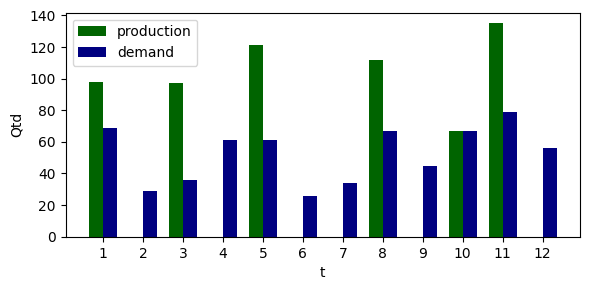

In [19]:
fig, ax = plt.subplots(figsize=[6, 3], dpi=100)
x = dataset.index
width = 0.35
ax.bar(x - width/2, dataset.production, width, color="darkgreen", label="production")
ax.bar(x + width/2, dataset.demand, width, color="navy", label="demand")
ax.set_xticks(x)
ax.set_ylabel("Qtd")
ax.set_xlabel("t")
ax.legend()
fig.tight_layout()
plt.show()